In [1]:
# 코드 8-1 라이브러리 호출
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim

In [2]:
# 코드 8-2 데이터셋 내려받기
trainset = torchvision.datasets.FashionMNIST(
    root="../chap08/data/", train=True, download=True, transform=transforms.ToTensor()
)

/home/halozhan/딥러닝 파이토치 교과서/.venv/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# 코드 8-3 데이터셋을 메모리로 가져오기
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [4]:
# 코드 8-4 데이터셋 분리
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
1


In [5]:
# 코드 8-5 이미지 데이터를 출력하기 위한 전처리
def imshow(img, title):
    plt.figure(figsize=(batch_size * 4, 4))  # 출력할 개별 이미지의 크기 지정
    plt.axis("off")
    plt.imshow(np.transpose(img, (1, 2, 0)))  # ①
    plt.title(title)
    plt.show()

In [6]:
# 코드 8-6 이미지 데이터 출력 함수
def show_batch_images(dataloader):
    images, labels = next(
        iter(dataloader)
    )  # 이미지의 크기는 (4, 28, 28, 1(배치 크기, 높이, 너비, 채널))이 됩니다.

    img = torchvision.utils.make_grid(
        images
    )  # 좌표에 이미지 픽셀을 대응시켜 그리드 형태로 출력합니다.
    imshow(
        img, title=[str(x.item()) for x in labels]
    )  # imshow 함수를 사용함으로써 데이터의 형태는 (채널, 높이, 너비)에서 (높이, 너비, 채널)로 변경됩니다.

    return images, labels

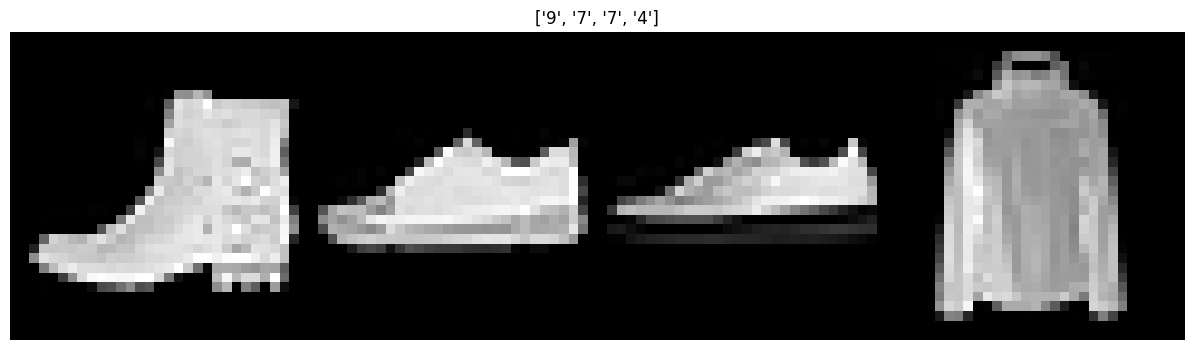

In [7]:
# 코드 8-7 이미지 출력
images, labels = show_batch_images(trainloader)

In [8]:
# 코드 8-8 배치 정규화가 적용되지 않은 네트워크
class NormalNet(nn.Module):
    def __init__(self):
        super(NormalNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(
                784, 48
            ),  # (28, 28) 크기의 이미지로 입력은 784(28×28) 크기가 됩니다.
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10),  # FashionMNIST의 클래스는 총 열 개
        )  # nn.Sequential을 사용하면 forward( ) 함수에서 계층(layer)별로 가독성 있게 코드 구현이 가능

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)  # nn.Sequential에서 정의한 계층 호출
        return x

In [9]:
# 코드 8-9 배치 정규화가 포함된 네트워크
class BNNet(nn.Module):
    def __init__(self):
        super(BNNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.BatchNorm1d(48),  # ①
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 10),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [10]:
# 코드 8-10 배치 정규화가 적용되지 않은 모델 선언
model = NormalNet()
print(model)

NormalNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [11]:
# 코드 8-11 배치 정규화가 적용된 모델 선언
model_bn = BNNet()
print(model_bn)

BNNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [12]:
# 코드 8-12 데이터셋 메모리로 불러오기
batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [13]:
# 코드 8-13 옵티마이저, 손실 함수 지정
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

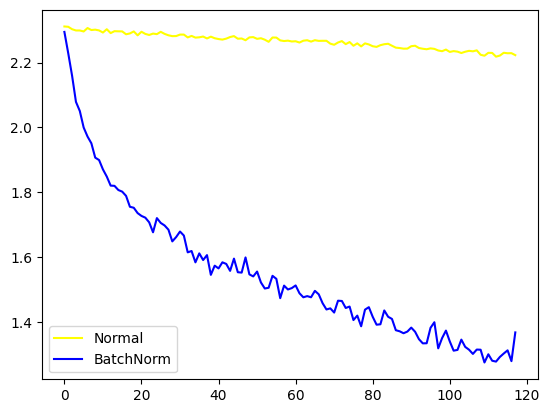

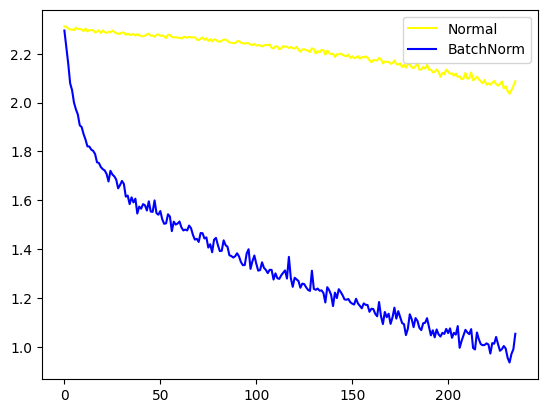

In [14]:
# 코드 8-14 모델 학습
loss_arr = []
loss_bn_arr = []
max_epochs = 2

for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        opt.zero_grad()  # 배치 정규화가 적용되지 않은 모델의 학습
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        opt_bn.zero_grad()  # 배치 정규화가 적용된 모델의 학습
        outputs_bn = model_bn(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()

        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())

    plt.plot(loss_arr, "yellow", label="Normal")
    plt.plot(loss_bn_arr, "blue", label="BatchNorm")
    plt.legend()
    plt.show()

In [15]:
# 코드 8-15 데이터셋의 분포를 출력하기 위한 전처리
N = 50
noise = 0.3

x_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)  # ①
y_train = x_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))  # ②

x_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_test = x_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

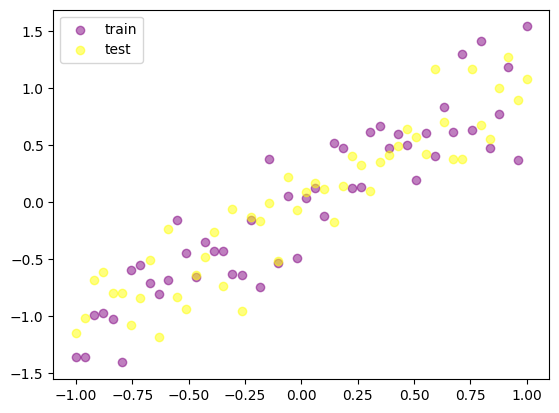

In [16]:
# 코드 8-16 데이터 분포를 그래프로 출력
plt.scatter(
    x_train.data.numpy(), y_train.data.numpy(), c="purple", alpha=0.5, label="train"
)  # ①
plt.scatter(
    x_test.data.numpy(), y_test.data.numpy(), c="yellow", alpha=0.5, label="test"
)
plt.legend()
plt.show()

In [17]:
# 코드 8-17 드롭아웃을 위한 모델 생성

N_h = 100
model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
) # 드롭아웃이 적용되지 않은 모델

model_dropout = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.Dropout(0.2), # 드롭아웃 적용
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
) # 드롭아웃이 적용된 모델

In [18]:
# 코드 8-18 옵티마이저와 손실 함수 지정
opt = torch.optim.Adam(model.parameters(), lr=0.01)
opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

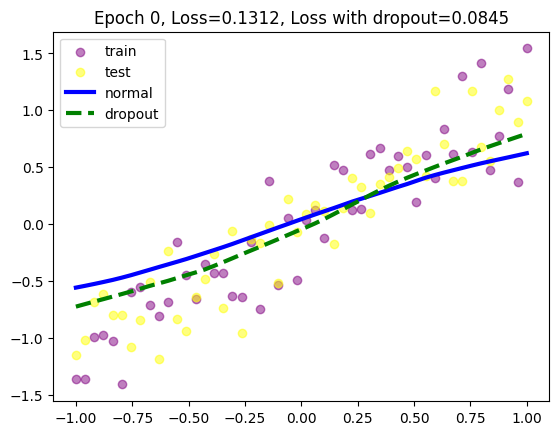

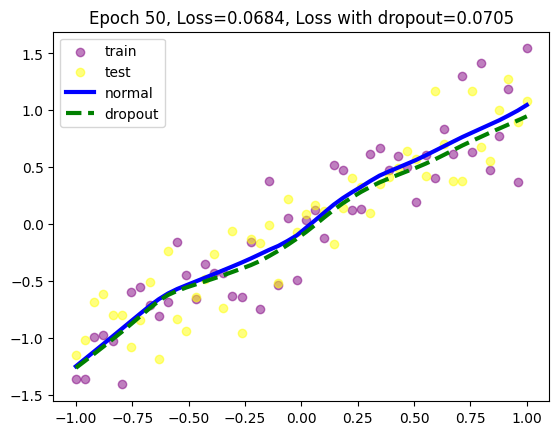

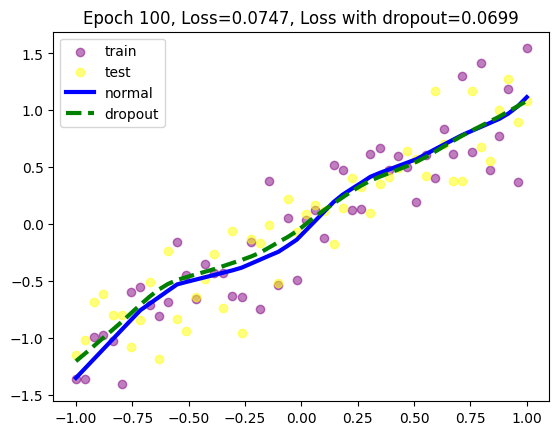

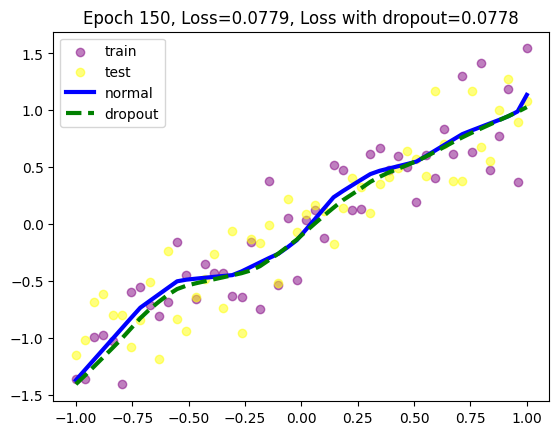

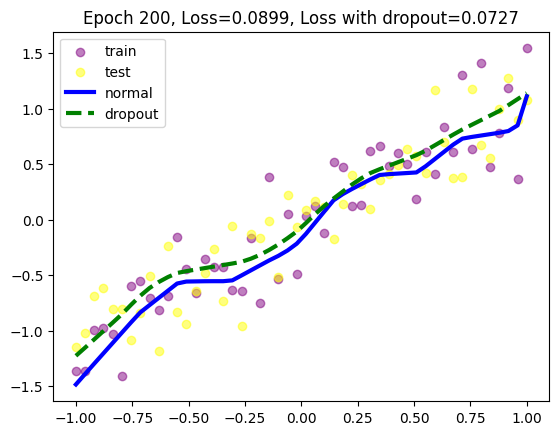

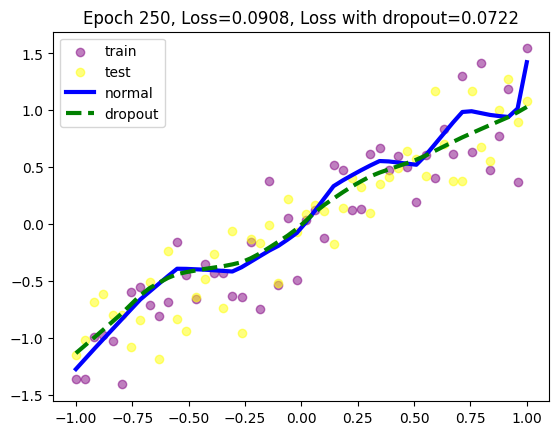

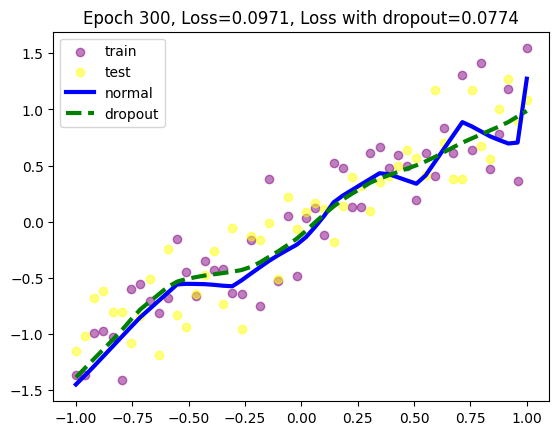

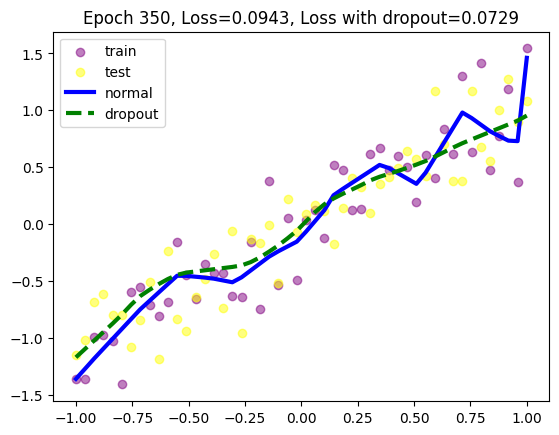

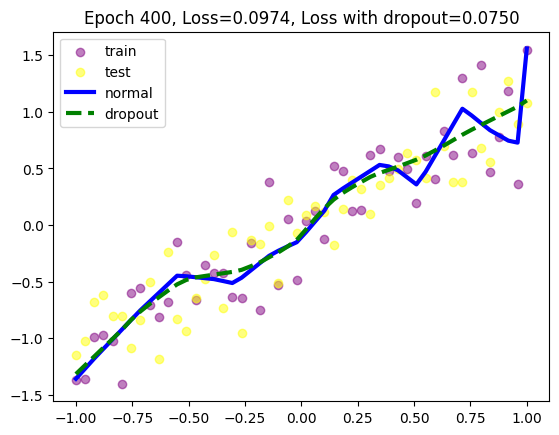

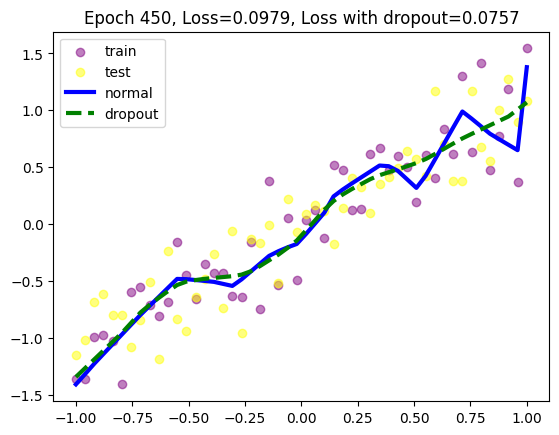

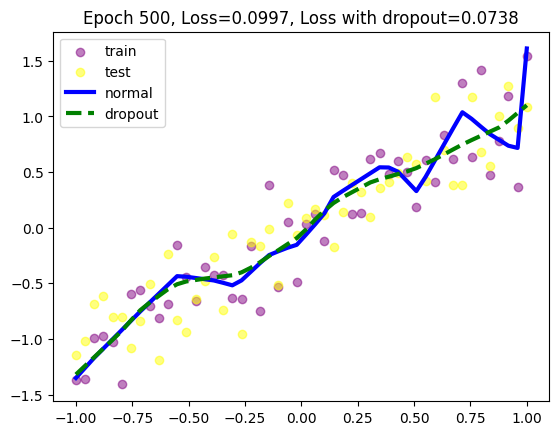

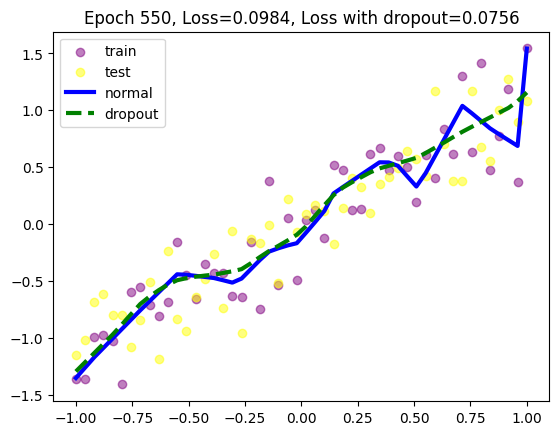

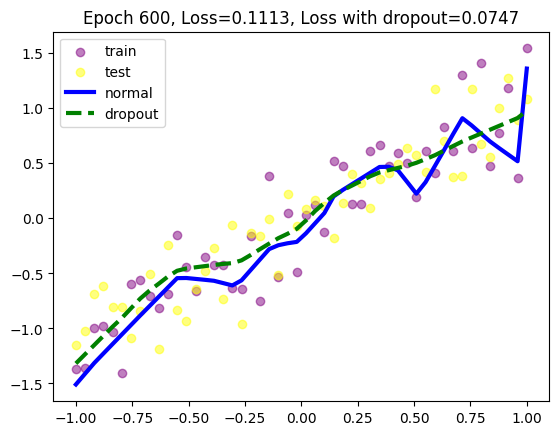

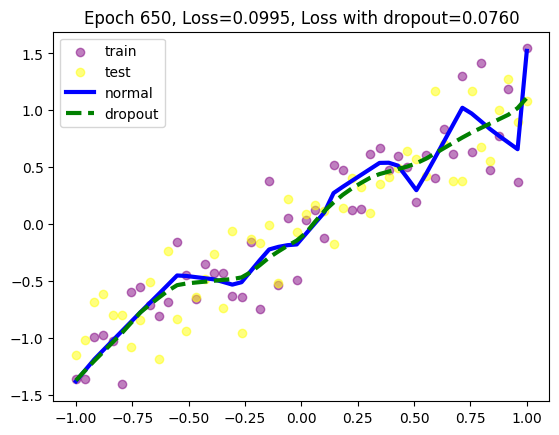

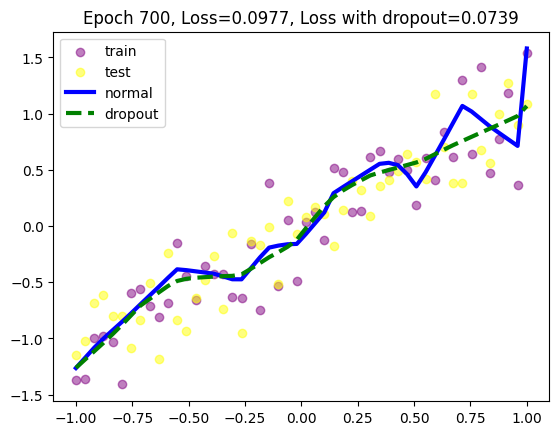

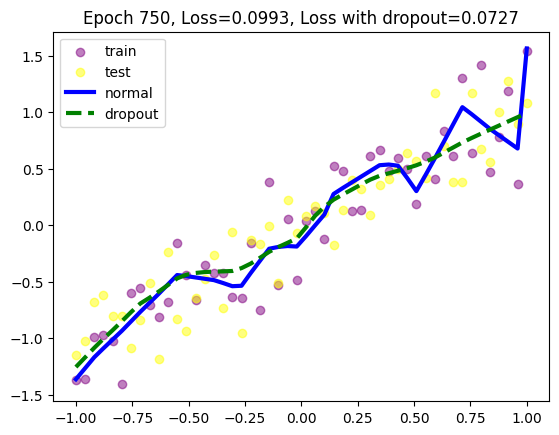

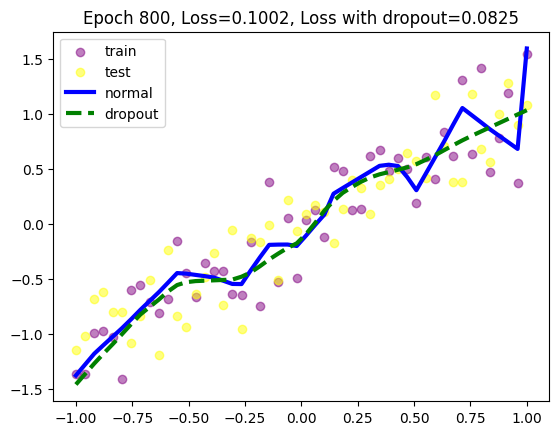

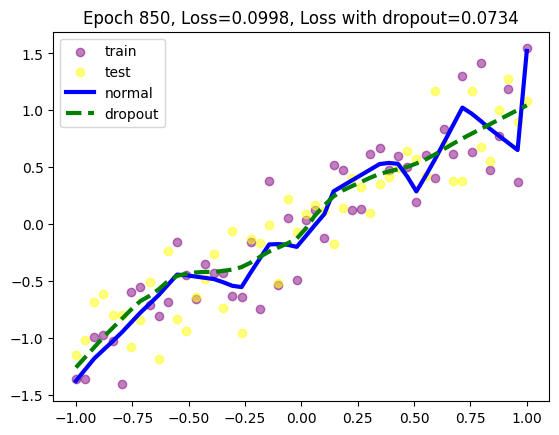

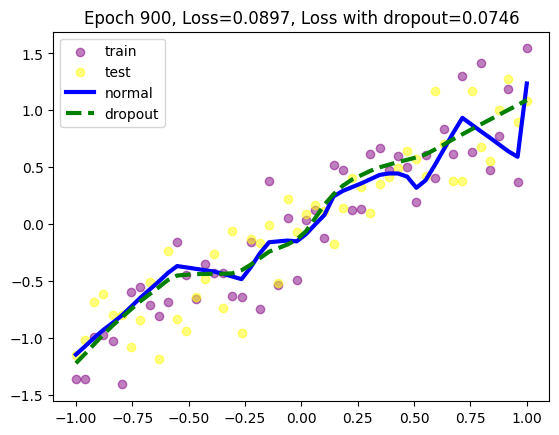

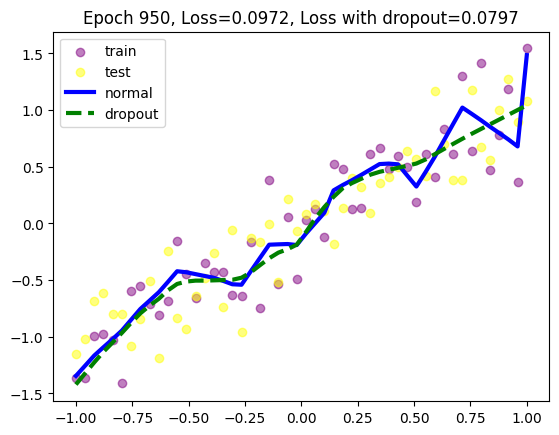

In [19]:
# 코드 8-19 모델 학습
max_epochs = 1000
for epoch in range(max_epochs):
    pred = model(x_train)  # 드롭아웃이 적용되지 않은 모델 학습
    loss = loss_fn(pred, y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()

    pred_dropout = model_dropout(x_train)  # 드롭아웃이 적용된 모델 학습
    loss_dropout = loss_fn(pred_dropout, y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()

    if epoch % 50 == 0:  # epoch를 50으로 나눈 나머지가 0이면 다음 진행
        model.eval()
        model_dropout.eval()

        test_pred = model(x_test)
        test_loss = loss_fn(test_pred, y_test)

        test_pred_dropout = model_dropout(x_test)
        test_loss_dropout = loss_fn(test_pred_dropout, y_test)

        plt.scatter(
            x_train.data.numpy(),
            y_train.data.numpy(),
            c="purple",
            alpha=0.5,
            label="train",
        )
        plt.scatter(
            x_test.data.numpy(),
            y_test.data.numpy(),
            c="yellow",
            alpha=0.5,
            label="test",
        )
        plt.plot(
            x_test.data.numpy(), test_pred.data.numpy(), "b-", lw=3, label="normal"
        )  # 파란색 실선으로 x축은 테스트 데이터셋, y축은 드롭아웃이 적용되지 않은 모델의 결과를 그래프로 출력
        plt.plot(
            x_test.data.numpy(),
            test_pred_dropout.data.numpy(),
            "g--",
            lw=3,
            label="dropout",
        )  # 초록색 점선으로 x축은 테스트 데이터셋, y축은 드롭아웃이 적용된 모델의 결과를 그래프로 출력
        plt.title(
            "Epoch %d, Loss=%0.4f, Loss with dropout=%0.4f"
            % (epoch, test_loss, test_loss_dropout)
        )  # 에포크, 드롭아웃이 적용되지 않은 모델의 오차, 드롭아웃이 적용된 모델의 오차를 타이틀로 출력
        plt.legend()
        model.train()
        model_dropout.train()
        plt.pause(0.05)